In [1]:
import os
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from dataset import PeptideDataset
from model import RetentionPredictor
from utils import evaluate_regression_metrics
from train_cmaes import train_cmaes_1_1
from train_de import train_de
from train_adam import train_adam

In [2]:
BATCH_SIZE = int(os.getenv("BATCH_SIZE"))
SEED = int(os.getenv("RANDOM_SEED"))
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
sns.set_theme(style="whitegrid")

In [4]:
HIDDEN_SIZES = [32, 16]
RANDOM_SEED = 123
BATCH_SIZE = 32

DATASETS = ["../data/krokhin.txt", "../data/mouse.txt" "../data/petritis.txt", "../data/serum.txt"]

ADAM_CONFIG = {"epochs": 150, "lr": 3e-4}
CMAES_CONFIG = {"generations": 500}
DE_CONFIG = {"generations": 500}

In [5]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)

In [6]:
def load_data(path):
    sequences, retention_times = [], []
    with open(path) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                seq, rt = parts
                sequences.append(seq)
                retention_times.append(float(rt))
    dataset = PeptideDataset(sequences, retention_times)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, val_size])

In [7]:
def run_experiment(algorithm, dataset_path, config):
    set_seed(RANDOM_SEED)
    train_data, val_data = load_data(dataset_path)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

    model = RetentionPredictor()
    criterion = nn.SmoothL1Loss()

    start = time.time()

    if algorithm == "adam":
        model, history = train_adam(model, criterion, train_loader, val_loader, **config)
    elif algorithm == "cmaes":
        model, history = train_cmaes_1_1(model, criterion, train_loader, val_loader, config)
    elif algorithm == "de":
        model, history = train_de(model, criterion, train_loader, val_loader, config)
    else:
        raise ValueError("Unknown algorithm")

    elapsed = time.time() - start
    metrics = evaluate_regression_metrics(model, val_loader)

    return {
        "algorithm": algorithm,
        "dataset_name": os.path.basename(dataset_path),
        "history": history,
        "final_metrics": {
            **metrics,
            "train_loss": history["train_loss"][-1],
            "val_loss": history["val_loss"][-1],
            "eval_calls": history["eval_calls"],
            "train_time": elapsed
        }
    }

In [8]:
def plot_learning_curves(history, label):
    plt.plot(history["generation"], history["train_loss"], label=f"Train - {label}")
    plt.plot(history["generation"], history["val_loss"], label=f"Val - {label}")
    plt.xlabel("Generation")
    plt.ylabel("Loss")
    plt.legend()

In [ ]:
def summarize_results(res):
    print("\n\nFinal Metrics Summary:")
    print("="*40)
    print(f"{res['algorithm'].upper()} | Dataset: {res['dataset_name']} | Val R2: {res['final_metrics']['r2']:.3f} | MAE: {res['final_metrics']['mae']:.4f} | Eval Calls: {res['final_metrics']['eval_calls']} | Time: {res['final_metrics']['train_time']:.2f}s")


===== Dataset: ../data/krokhin.txt =====
Running ADAM...
Epoch   1/150 | Train Loss: 0.06380 | Val Loss: 0.08071
Epoch   2/150 | Train Loss: 0.05112 | Val Loss: 0.06705
Epoch   3/150 | Train Loss: 0.04210 | Val Loss: 0.05615
Epoch   4/150 | Train Loss: 0.03625 | Val Loss: 0.04772
Epoch   5/150 | Train Loss: 0.03073 | Val Loss: 0.04079
Epoch   6/150 | Train Loss: 0.02599 | Val Loss: 0.03517
Epoch   7/150 | Train Loss: 0.02283 | Val Loss: 0.03049
Epoch   8/150 | Train Loss: 0.01955 | Val Loss: 0.02655
Epoch   9/150 | Train Loss: 0.01803 | Val Loss: 0.02340
Epoch  10/150 | Train Loss: 0.01638 | Val Loss: 0.02064
Epoch  11/150 | Train Loss: 0.01474 | Val Loss: 0.01828
Epoch  12/150 | Train Loss: 0.01333 | Val Loss: 0.01634
Epoch  13/150 | Train Loss: 0.01204 | Val Loss: 0.01461
Epoch  14/150 | Train Loss: 0.01116 | Val Loss: 0.01309
Epoch  15/150 | Train Loss: 0.01052 | Val Loss: 0.01180
Epoch  16/150 | Train Loss: 0.00957 | Val Loss: 0.01073
Epoch  17/150 | Train Loss: 0.00859 | Val Loss

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

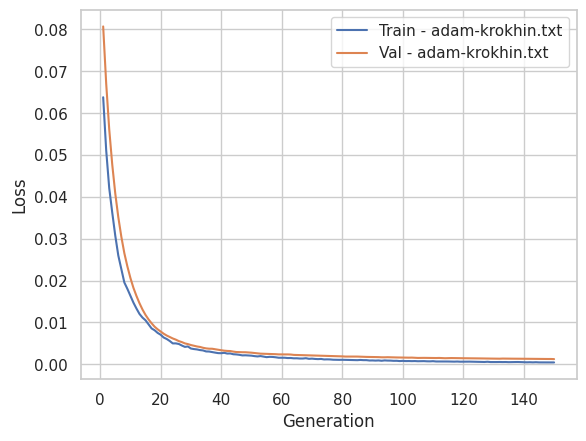

In [ ]:
all_results = []
for dataset in DATASETS:
    print(f"\n===== Dataset: {dataset} =====")
    for alg, cfg in zip(["adam", "cmaes", "de"], [ADAM_CONFIG, CMAES_CONFIG, DE_CONFIG]):
        print(f"Running {alg.upper()}...")
        result = run_experiment(alg, dataset, cfg)
        summarize_results(result)
        all_results.append(result)
        plot_learning_curves(result["history"], label=f"{alg}-{os.path.basename(dataset)}")

plt.title("Learning Curves")
plt.tight_layout()
plt.savefig(f'../results/fig{time.time_ns}.png')
plt.show()

for res in all_results:
    summarize_results(res)